In [14]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier

from frouros.datasets.synthetic import SEA
from frouros.detectors.concept_drift import DDM, DDMConfig
from frouros.metrics.prequential_error import PrequentialError

# Drift detection method (DDM)

This example demonstrates the application of the concept drift detection method DDM {cite:p}`gama2004learning` with data stream blocks (concepts) generated by the SEA {cite:p}`street2001streaming`.

## Definition of concepts in SEA

According to the artificial data generated in SEA {cite:p}`street2001streaming`, a concept or block is defined by the following rule:

$$
\text{class}(x) = \left\{
  \begin{array}{ll}
    1 & \text{if } x_1 + x_2 \leq \theta \\
    0 & \text{otherwise}
  \end{array}
\right.
$$

Here, $x_1$ and $x_2$ are two features (SEA includes another feature $x_3$, which is irrelevant), and $\theta$ is a threshold that differentiates the two classes. Four different concepts/blocks are defined based on the value of $\theta$: Concept 1 ($\theta = 8$), Concept 2 ($\theta = 9$), Concept 3 ($\theta = 7$), and Concept 4 ($\theta = 9.5$).

## Definition of phases

In this case, Concepts 1 and 3 are used without any added noise. Concept 1 is employed for training a model, warming up the detector, and also during the testing phase. On the other hand, Concept 3 is only used to induce concept drift during the testing phase.

The two different concepts are represented in two distinct phases: the warm up phase, where $\theta_{\text{warm up}}(t) = 8$ (Concept 1), and the testing phase, where Concept 1 is initially used to demonstrate that the detector is not triggered by the same concept. Later, Concept 3 is introduced to trigger a drift signal:

$$
\theta_{\text{test}}(t) = \left\{
  \begin{array}{ll}
    8 & \text{if } 0 \leq t < 10000 \\
    7 & \text{if } 10000 \leq t < 20000 \\
  \end{array}
\right.
$$

## Data generation for training, warm up and testing

The data for both the training and warm up phases is generated using the SEA generator with Concept 1. The number of samples is set to 20000, with 10000 samples used for training and 10000 for warming up the detector.

In [15]:
random_state = 31

concept_samples = 20000
generator = SEA(seed=random_state)
noise = 0.0

reference_concept = generator.generate_dataset(
    block=1,  # Concept 1
    noise=noise,
    num_samples=concept_samples,
)

X_reference, y_reference = [], []
for sample, label in reference_concept:
    X_reference.append(sample)
    y_reference.append(label)
X_reference, y_reference = np.array(X_reference), np.array(y_reference).reshape(-1, 1)

## Shuffle data to avoid bias
idx = np.arange(len(X_reference))
np.random.shuffle(idx)
X_reference, y_reference = X_reference[idx], y_reference[idx]

split_idx = concept_samples // 2  # 10000 each subset (train and warmup)
X_train, y_train = X_reference[:split_idx], y_reference[:split_idx]
X_warmup, y_warmup = X_reference[split_idx:], y_reference[split_idx:]

The test dataset is generated by using the SEA generator with Concept 1 and Concept 3. Concept 1 is expected to not trigger any drift, while Concept 3 should trigger a drift signal.

In [16]:
test_concepts = [generator.generate_dataset(
    block=block,
    noise=noise,
    num_samples=10000,
) for block in [1, 3]]  # Concepts 1 and 3

X_test, y_test = [], []
for concept in test_concepts:
    for sample, label in concept:
        X_test.append(sample)
        y_test.append(label)

X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1, 1)

## Detector definition

A configuration class with detector parameters is defined. In this particular case, it only contains the warning and drift threshold levels, along with the minimum number of instances to start checking for drift. The minimum number of instances is set to the number of samples in the warm up dataset, meaning that the detector will start checking for drift from the first sample of the test dataset. It will trigger a drift signal if the expected error is significantly higher than the error obtained in the warm up dataset.

 The detector can be defined by passing the previously defined configuration class.

In [17]:
config = DDMConfig(
    warning_level=2.0,
    drift_level=3.0,
    min_num_instances=len(X_warmup),  # Minimum number of instances to start checking for drift
)

detector = DDM(
    config=config,
)

## Model definition

To train our model, we use a straightforward approach by fitting a simple decision tree classifier to the training dataset. The classifier is configured with default parameters for simplicity.

In [18]:
model = DecisionTreeClassifier(
    random_state=random_state,
)
model.fit(
    X=X_train,
    y=y_train,
)

DecisionTreeClassifier(random_state=31)

## Tracking metrics in stream simulation

During the simulation of the data stream, various metrics are employed and monitored. In this scenario, we focus on the prequential error, configuring it with different fading factors: $\alpha = 1.0$, $\alpha = 0.9999$, and $\alpha = 0.999$.

- When $\alpha = 1.0$, the prequential error acts as an accuracy metric, assigning equal weight to the error of each sample. This implies that every sample contributes equally to the overall error calculation.

- For $\alpha = 0.9999$, 99.99% of the weight is assigned to the previous samples, while the remaining 0.01% is allocated to the new error value. This weighting emphasizes the historical performance of the model, with some focus on recent samples.

- Similarly, with $\alpha = 0.999$, 99.9% of the weight is attributed to the previous samples, and 0.1% is allocated to the new error value, emphasizing the historical performance of the model with a stronger focus on recent samples.

This approach allows for a nuanced evaluation of the model's performance, capturing both overall accuracy and the evolving impact of recent data on the error calculation.

In [19]:
metrics = [
    PrequentialError(
        alpha=alpha,
        name=f"α={alpha}",
    )
    for alpha in [1.0, 0.9999, 0.999]
]
metrics_historic_detector = {f"{metric.name}": [] for metric in metrics}

## Error scorer

To assess model performance, we define a straightforward error scorer function. This function returns 0 if the prediction is correct and 1 otherwise, serving as a binary indicator of prediction accuracy.

In [20]:
def error_scorer(y_true, y_pred):  # Error function
    return 1 - (y_true.item() == y_pred.item())

## Warm up phase

The warm up phase serves as a fitting period during which the detector sequentially processes warm up samples, updating its internal state. In this specific scenario, samples from `X_warmup` are utilized to initialize and train the detector.

This fitting phase allows the detector to adapt to the characteristics of the warm up data, establishing a baseline for normal behavior. The sequential processing of samples ensures that the detector gradually incorporates information from the warm up dataset, setting the stage for subsequent testing and drift detection.

In [21]:
# Warm-up detector
print(f"Warming up detector with {len(X_warmup)} samples")

for X, y in zip(X_warmup, y_warmup):
    y_pred = model.predict(X=X.reshape(1, -1))
    error = error_scorer(y_true=y, y_pred=y_pred)
    _ = detector.update(value=error)

    for metric_historic, metric in zip(metrics_historic_detector.keys(), metrics):
        metrics_historic_detector[metric_historic].append(metric(error))

Warming up detector with 10000 samples


## Testing phase

To showcase the detector's functionality, a data stream is simulated by iterating over the test dataset. In this demonstration, we assume that all ground-truth values are available in sequential order. It's important to note that while we iterate over the data sequentially for this example, the `update` method of the detector object could be called on demand and not strictly in sequential order. This flexibility is particularly useful, allowing for non-sequential updates as needed.

The simulation involves feeding each instance of the test dataset to the model, which returns a prediction. The prediction is then compared to the ground-truth value, and the error is calculated. The error is then passed to the detector, which updates its internal state. The detector's status is then checked, and if a drift is detected, the simulation stops. Otherwise, the process continues until the end of the test dataset is reached.

In [22]:
idx_drift, idx_warning = [], []
i = len(X_warmup)
for X, y in zip(X_test, y_test):
    y_pred = model.predict(X=X.reshape(1, -1))  # Model's prediction
    error = error_scorer(y_true=y, y_pred=y_pred)
    _ = detector.update(value=error)  # Detector's update

    # All the following lines are optional and only used for plotting the whole process
    for metric_historic, metric in zip(metrics_historic_detector.keys(), metrics):
        metrics_historic_detector[metric_historic].append(metric(error))

    status = detector.status
    if status["drift"]:
        # Drift detected
        print(f"Drift detected at index: {i}")
        idx_drift.append(i)
        detector.reset()  # Reset detector
        for metric in metrics:  # Reset metrics
            metric.reset()
        break  # Stop simulation
    elif status["warning"]:
        # Warning zone
        idx_warning.append(i)
    i += 1

Drift detected at index: 20299


### Visualizing model performance and detector interactions

To provide a comprehensive view, the performance of the model over time and its interactions with the detector are visualized through plots.

This visual representation captures the evolution of the model's accuracy or error rates (prequential error) as the data stream progresses. Additionally, the detector's responses to potential concept drifts are illustrated, showcasing moments when the detector signals a concept drift or enters a warning zone.

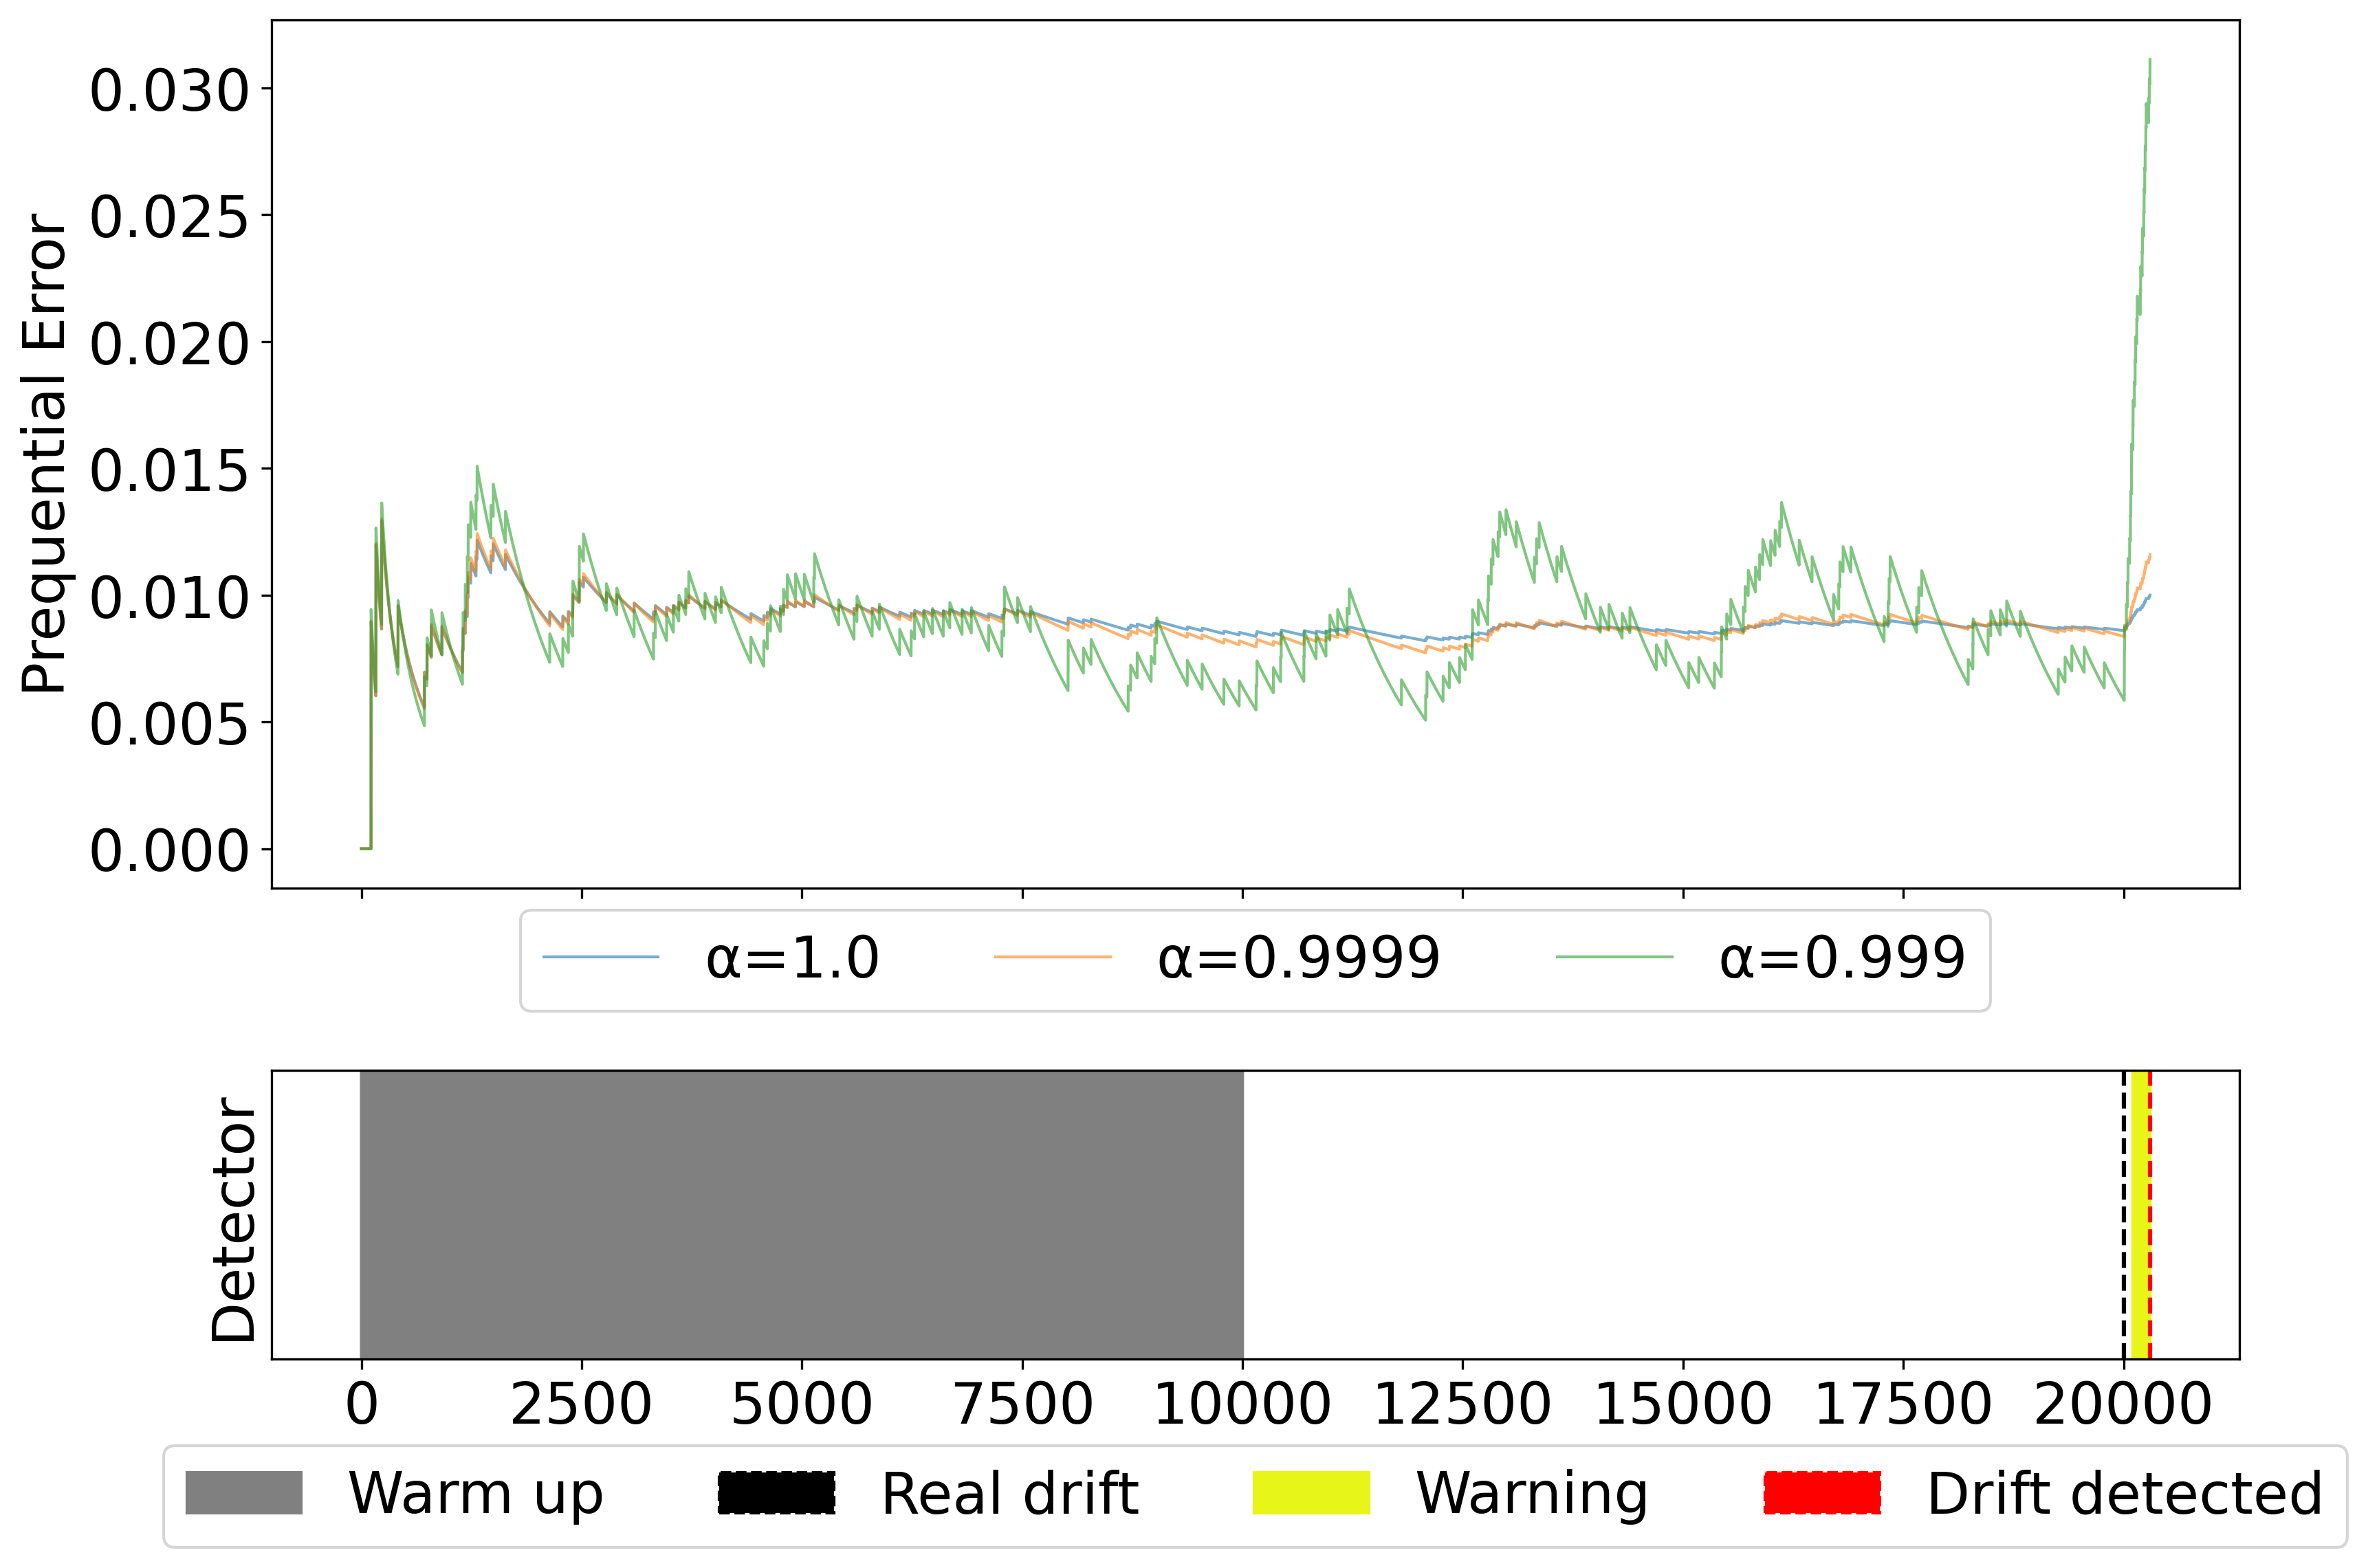

In [23]:
plt.rcParams.update({'font.size': 20})

alpha = 0.6
linewidth = 1.0

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 8),
    sharex=True,
    dpi=300,
    gridspec_kw={'height_ratios': [3, 1]},
)

for (metric_name, metric_values), linecolor in zip(
        metrics_historic_detector.items(),
        ["#1f77b4", "#ff7f0e", "#2ca02c"],
):
    ax[0].plot(metric_values,
               color=linecolor,
               linewidth=linewidth,
               alpha=alpha,
               label=metric_name)

drift_color = "red"
drift_linestyle = "--"
warmup_color = "grey"
warning_color = "#e8f519"
real_drift_color = "black"

for idx in range(0, len(X_warmup)):
    ax[1].axvline(x=idx,
                  color=warmup_color,
                  linewidth=linewidth)

for idx in idx_warning:
    ax[1].axvline(x=idx,
                  color=warning_color,
                  linewidth=linewidth)

for idx in idx_drift:
    ax[1].axvline(x=idx,
                  color=drift_color,
                  linestyle=drift_linestyle,
                  linewidth=1.5)

ax[0].set_ylabel("Prequential Error")
ax[0].legend(
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.175),
    fancybox=True,
)
ax[1].set_yticks([])
ax[1].set_ylabel("Detector")
drift_path = mpatches.Patch(color=drift_color, label="Drift detected", linestyle=drift_linestyle)
warning_path = mpatches.Patch(color=warning_color, label="Warning")
warmup_path = mpatches.Patch(color=warmup_color, label="Warm up")
real_drift_path = mpatches.Patch(color=real_drift_color, label="Real drift", linestyle=drift_linestyle)
ax[1].axvline(x=20000,
              color=real_drift_color,
              linestyle=drift_linestyle,
              linewidth=1.5)
ax[1].legend(
    handles=[warmup_path, real_drift_path, warning_path, drift_path],
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.2),
    fancybox=True,
)

fig.tight_layout()
plt.show()

### Interpretation of results

Assuming the detector has been pre-warmed on Concept/Block 1 of the SEA {cite:p}`street2001streaming` generator, the results can be interpreted as follows:

- **[0 - 9999] (Concept 1):**
  - The detector is pre-warmed with 10000 samples from Concept 1, and the error remains stable at less than 1% (indicated by prequential error metric). During this phase, the detector is not yet capable of detecting drift, as the minimum number of instances required to start drift detection is set to 10000 (the number of samples in the warm up dataset).

- **[10000 - 19999] (Concept 1):**
  - The detector is now ready to initiate drift detection. Despite using samples from Concept 1, the error remains stable, and the detector does not detect drift, aligning with the expected behavior.

- **[20000 - 20299] (Concept 3):**
  - Subsequently, the detector starts receiving samples from Concept 3, leading to a significant increase in error, as observed in the plot. The detector enters a warning zone, and shortly after, at index 20299, drift is detected.

Since no callback is employed, the user is left to decide the subsequent steps. It's a choice between continuing the model in its current state, being aware of the detected concept change, or opting to retrain the model.

```{bibliography}
:filter: docname in docnames
```